### Stationarity and Time Series Shifting  
  
This notebook is for using Augmented Dickey-Fuller to test for stationarity of time series data and exploring shifting different windows to make that window stationary.  
  
Fourier Transforms treat the time series data as stationary, but EEG data isn't stationary. For this reason, methods like Short-Time Fourier Transform and Wavelet Transform are used. Short-Time Fourier Transform still treats the data as stationary, but it segments the time series by a set window length and does Fourier Transforms on those windows of the time series. By segmenting the time series, you create time series which are more likely to be stationary. However, you can also generate stationary time series by shifting the time series. The thought is using ADF to determine when a segment is non-stationary and then shifting until it's stationary might help generate better STFT results and then better band power analysis results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fastparquet, pyarrow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

### Data Loading and Splitting  
  
Metadata with Nulls Removed

In [2]:
df = pd.read_csv('working_data.csv')

In [32]:
def activity_df(activity_type):
    return df[df['expert_consensus'] == activity_type].reset_index().drop(columns = 'index')

seizure_df = activity_df('Seizure')
lpd_df = activity_df('LPD')
gpd_df = activity_df('GPD')
lrda_df = activity_df('LRDA')
grda_df = activity_df('GRDA')
other_df = activity_df('Other')

### Function to Load and Scale Sub EEGs

In [33]:
def scale(df, row):
    eeg = pd.read_parquet('train_eegs/{}.parquet'.format(df['eeg_id'][row]), engine = 'pyarrow')
    start = int(df['eeg_label_offset_seconds'][row] * 200)
    finish = start + 10000
    sub_eeg = eeg[start: finish]
    sub_eeg = sub_eeg.reset_index().drop(columns = 'index')
    electrodes = sub_eeg.columns
    scaler = StandardScaler()
    sub_eeg = scaler.fit_transform(sub_eeg)
    return pd.DataFrame(sub_eeg, columns = electrodes)

### Function to Convert to Pandas Series and Check Augmented Dickey Fuller

In [37]:
def check_adf(sub_eeg, electrode):
    time_series = pd.Series(sub_eeg[electrode])
    if adfuller(time_series)[1] <= 0.05:
        return True
    else:
        return False

In [39]:
seizure_randoms = np.random.choice([i for i in range(seizure_df.shape[0])], size = 5, replace = False)
lpd_randoms = np.random.choice([i for i in range(lpd_df.shape[0])], size = 5, replace = False)
gpd_randoms = np.random.choice([i for i in range(gpd_df.shape[0])], size = 5, replace = False)
lrda_randoms = np.random.choice([i for i in range(lrda_df.shape[0])], size = 5, replace = False)
grda_randoms = np.random.choice([i for i in range(grda_df.shape[0])], size = 5, replace = False)
other_randoms = np.random.choice([i for i in range(other_df.shape[0])], size = 5, replace = False)

In [42]:
for i in seizure_randoms:
    print(check_adf(scale(seizure_df, i), 'F7'))

False
True
True
False
True


In [48]:
seizure_randoms[0], seizure_randoms[3]

(6301, 2147)

In [54]:
nonstationary1 = scale(seizure_df, 6301)
nonstationary2 = scale(seizure_df, 2147)

In [68]:
check_adf(nonstationary1, 'F7')

False

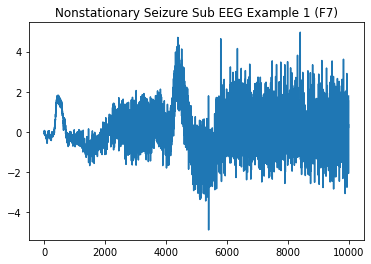

In [55]:
plt.plot(nonstationary1['F7'])
plt.title('Nonstationary Seizure Sub EEG Example 1 (F7)')
plt.show()

In [67]:
check_adf(nonstationary1[6000:10000], 'F7')

True

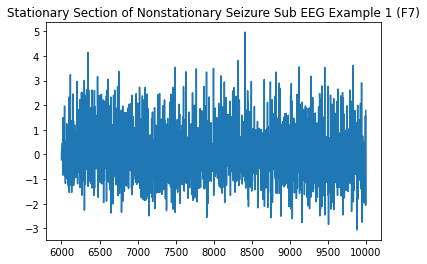

In [65]:
plt.plot(nonstationary1[6000:10000]['F7'])
plt.title('Stationary Section of Nonstationary Seizure Sub EEG Example 1 (F7)')
plt.show()

In [69]:
check_adf(nonstationary2, 'F7')

False

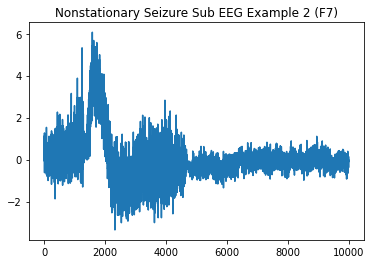

In [51]:
plt.plot(nonstationary2['F7'])
plt.title('Nonstationary Seizure Sub EEG Example 2 (F7)')
plt.show()

In [70]:
check_adf(nonstationary2[6000:10000], 'F7')

True

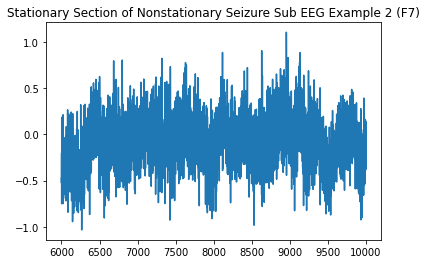

In [71]:
plt.plot(nonstationary2[6000:10000]['F7'])
plt.title('Stationary Section of Nonstationary Seizure Sub EEG Example 2 (F7)')
plt.show()

In [43]:
for i in lpd_randoms:
    print(check_adf(scale(lpd_df, i), 'F7'))

True
True
True
True
True


In [44]:
for i in gpd_randoms:
    print(check_adf(scale(gpd_df, i), 'F7'))

True
True
True
True
True


In [45]:
for i in lrda_randoms:
    print(check_adf(scale(lrda_df, i), 'F7'))

True
True
True
True
True


In [46]:
for i in grda_randoms:
    print(check_adf(scale(grda_df, i), 'F7'))

True
True
True
True
True


In [47]:
for i in other_randoms:
    print(check_adf(scale(other_df, i), 'F7'))

True
True
True
True
True
